<a href="https://colab.research.google.com/github/jandyr/ProSeisSN_Nbk/blob/main/Nbook03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing passive seismic data

This notebook deals with data processing using a passive seismic dataset using [ObsPy](https://docs.obspy.org/).

## It is intended to be run in Colab.


#### Dependencies: Obspy, Numpy, Matplotlib

#### Reset the Jupyter/IPython notebook in order to run it again, press:
***Kernel*** -> ***Restart & Clear Output***

---
## Install Conda and create an *environment*, and install the required *packages* for the work.

* The `condacolab` commands need to be run as the first Code cell!
* After `condacolab.install()`, the Python kernel will be restarted.
* Do not use the `Run all` option. Run the `condacolab` cell _individually_ and wait for the kernel to restart.
* You can only use the `base` environment. Do not try to create new ones; instead update `base` with either:
  * `conda install <packages>`
  * `conda env update -n base -f environment.yml`

## ***Attn:***
###1) Click "Runtime" then "Restart runtime", otherwise obspy may report some error.

###2) Every time you quit or reset the runtime, you wil need to install Conda again.

In [1]:
# Import and install condacolab python library.
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
#------------  RESTART kernel HERE!  ------------
# Remove the pip installation of ObsPy for sanity reasons.
#!pip uninstall obspy -y
import condacolab
condacolab.check()
!conda init

✨🍰✨ Everything looks OK!
no change     /usr/local/condabin/conda
no change     /usr/local/bin/conda
no change     /usr/local/bin/conda-env
no change     /usr/local/bin/activate
no change     /usr/local/bin/deactivate
no change     /usr/local/etc/profile.d/conda.sh
no change     /usr/local/etc/fish/conf.d/conda.fish
no change     /usr/local/shell/condabin/Conda.psm1
no change     /usr/local/shell/condabin/conda-hook.ps1
no change     /usr/local/lib/python3.10/site-packages/xontrib/conda.xsh
no change     /usr/local/etc/profile.d/conda.csh
no change     /root/.bashrc
No action taken.


In [3]:
# Verify the Conda installation. Update.
!conda update -n base -c conda-forge conda --yes
!conda --version

# Create base environment
!conda create -n base python=>3.9 -y

# Locate the Conda package. Verify the Conda installation.
!conda info
!which conda

# Create a new conda environment
!conda create -n pSeis python=>3.9 -y

# Activate the environment
!conda activate pSeis

!python -m ipykernel install --user --name pSeis --display-name "pSeis"

!conda env list

# Install needed packages
# obspy>=3.8 numpy>=1.15.0 scipy>=1.4.0
!conda install -c conda-forge pandas numpy matplotlib numpy scipy utm segyio collections
# Install the certifi package, which is a dependency of the cartopy package, that obspy depends on.
!conda install -c conda-forge certifi cartopy
!conda install -c conda-forge obspy

#sanity
try:
    import obspy
except:
    !pip install obspy

# Import specialized ObsPy packages. Sanity.
try:
    import obspy
    print('obspy version==>', obspy.__version__)
except TypeError:
    print('Stopping RUNTIME. If run for the first time Colab should be restarted. Run again.')
    exit()

from obspy import read
from obspy import UTCDateTime
from obspy import read, Stream

!echo "Conda environment created!"

Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

conda 23.11.0

CondaValueError: The target prefix is the base prefix. Aborting.


     active environment : None
       user config file : /root/.condarc
 populated config files : /usr/local/.condarc
          conda version : 23.11.0
    conda-build version : not installed
         python version : 3.10.13.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=broadwell
                          __conda=23.11.0=0
                          __glibc=2.35=0
                          __linux=6.1.85=0
                          __unix=0=0
       base environment : /usr/local  (writable)
      conda av data dir : /usr/local/etc/conda
  

In [4]:
# Enables using the interactive features of matplotlib in Jupyter Notebooks, Jupyter Lab, Google Colab.
# https://matplotlib.org/ipympl/
!conda install -c conda-forge ipympl

# Matplotlib aware interact functions
!conda install -c conda-forge mpl-interactions

# Import matplotlib and alias it as 'plt'
import matplotlib.pyplot as plt
#from matplotlib import pyplot as plt
from mpl_interactions import ioff, panhandler, zoom_factory

# matplotlib magic command for Colab
%matplotlib inline
%matplotlib ipympl
# matplotlib magic command for local Notebook
#%matplotlib notebook

Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - \ | / failed

PackagesNotFoundError: The following packages are not available from current channels:

  - conda-forge

Current channels:

  - https://conda.anaconda.org/conda-forge

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




Support for third party widgets will remain active for the duration of the session. To disable support:

---
### Accessing a local data

We work with data form the event occured in Acre in 2024 in miniSEED format.

|EventID | Time | Lat | Long | Depth(km) | Mww | Location |
| :- | :-: | :- | :- | :-: | :-: | :- |
|11793085|2024-01-20T21:31|-7.2879|-71.464|607|6.6|WESTERN BRAZIL|

As recorded at station IU HKT, distant $44^{\circ}$ from the event.

|Station|Seismometer| Lat | Long | Depth(m) | Channels |
| :- | :- | :- | :- | :-: | :-: |
|HKT: Hockley1 Texas|Streckeisen STS-6A VBB |29.96|-95.84|93|BH1, BH2, BHZ|

Remove the instrument response.

Use the read function with the path to the data file.

**st** is a stream object, which contains the data and associated metadata. The data are collections of trace objects.

In [5]:
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.header import FDSNException

# Specify start and end times
starttime = UTCDateTime("2024-01-20T21:37:19.019539Z") - 60
endtime = UTCDateTime("2024-01-20T21:58:18.994539Z")
print(starttime, endtime)

# Use wildcards to select all three HH* channels
net = "IU"
sta = "HKT"
loc = "00"
chan = "HH*"

# Specify client. Opt:from obspy.clients.earthworm import Client
# Get waveforms with instrument response into a stream
#
try:
    client = Client("IRIS")
    st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)
except:
    from obspy.clients.earthworm import Client
    client = Client("ETH")
    st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)

# Print the stream object
print(st)

# Remove instrument response. other options: output = 'DISP', 'ACC'
st.remove_response(output = 'VEL')

!ls -l ./sample_data/
#  st = read('./sample_data/wb11793085_ir.mseed')

2024-01-20T21:36:19.019539Z 2024-01-20T21:58:18.994539Z
3 Trace(s) in Stream:
IU.HKT.00.HH1 | 2024-01-20T21:36:19.028394Z - 2024-01-20T21:43:14.538394Z | 100.0 Hz, 41552 samples
IU.HKT.00.HH2 | 2024-01-20T21:36:19.028394Z - 2024-01-20T21:43:17.648394Z | 100.0 Hz, 41863 samples
IU.HKT.00.HHZ | 2024-01-20T21:36:19.028394Z - 2024-01-20T21:43:17.688394Z | 100.0 Hz, 41867 samples
total 55504
-rwxr-xr-x 1 root root     1697 Jan  1  2000 anscombe.json
-rw-r--r-- 1 root root   301141 Sep 11 13:23 california_housing_test.csv
-rw-r--r-- 1 root root  1706430 Sep 11 13:23 california_housing_train.csv
-rw-r--r-- 1 root root 18289443 Sep 11 13:23 mnist_test.csv
-rw-r--r-- 1 root root 36523880 Sep 11 13:23 mnist_train_small.csv
-rwxr-xr-x 1 root root      930 Jan  1  2000 README.md


---
### The frequency content

The [spectrogram](https://docs.obspy.org/tutorial/code_snippets/plotting_spectrograms.html) shows the power in frequency bands (along the y-axis) for every few samples in time (along the x-axis). Warmer colours indicate more power - this station has most of it's power below 1 Hz, which is common for a time-period dominated by seismic noise.

               network: IU
               station: HKT
              location: 00
               channel: HHZ
             starttime: 2024-01-20T21:36:19.028394Z
               endtime: 2024-01-20T21:43:17.688394Z
         sampling_rate: 100.0
                 delta: 0.01
                  npts: 41867
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 96, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 136704})
            processing: ['ObsPy 1.4.1: trim(endtime=UTCDateTime(2024, 1, 20, 21, 58, 18, 998394)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2024, 1, 20, 21, 36, 19, 18394))', "ObsPy 1.4.1: remove_response(fig=None::inventory=None::output='VEL'::plot=False::pre_filt=None::taper=True::taper_fraction=0.05::water_level=60::zero_mean=True)"]
              response: Channel R

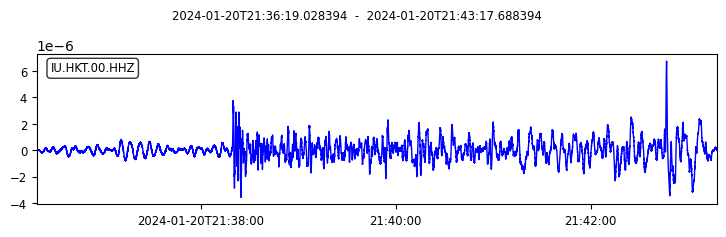

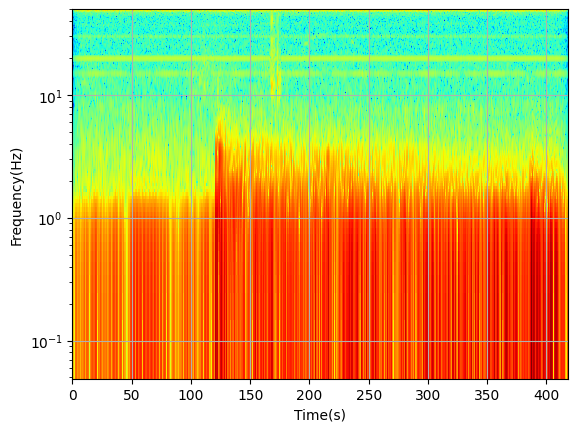

In [6]:
# Support for third party widgets, outside of the ipywidgets package, needs to be enabled separately, and
#  loaded from a CDN external from Colab.
from google.colab import output
output.enable_custom_widget_manager()

# matplotlib magic command for Colab
%matplotlib inline
#%matplotlib ipympl
#%matplotlib widget
# matplotlib magic command for local Notebook
#%matplotlib notebook

# Read the Z-component trace from the stream object. Print the trace metadata, e.g., tr.stats.npts
tr = st[-1]
print(tr.stats)

# Plot filtered trace
tr.plot(color = 'blue');

# Construct a figure for BHZ trace
fig, ax = plt.subplots()
_ = st[2].spectrogram(log=True, dbscale=True, axes=ax, show=True, cmap = "jet")
plt.xlabel("Time(s)")
plt.ylabel("Frequency(Hz)")
#plt.title("Plot Title")
#plt.legend() # If you have multiple lines in the plot
plt.grid(True) # Add a grid to the plot
plt.show()

## 3) Filtering
**ObsPy** has several [filters](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.filter.html).:
- "bandpass" filters *retain* a frequency range $\Delta f=\left[f_{1},f_{2}\right]=f_{1}\leq\Delta f\leq f_{2}$;
- "lowpass" filters *retain* the frequency range $\Delta f\leq f_{cutoff}$;
- "highpass" filters *retain* the frequency range $\Delta f\geq f_{cutoff}$;
- "notch" filters *remove* the frequency range $f_{1}\leq\Delta f\leq f_{2}$, therefore does the *opposite* of bandpass.



HHZ


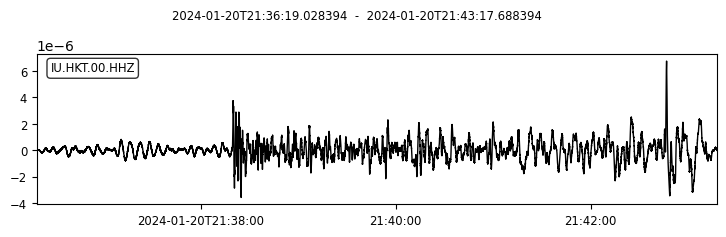

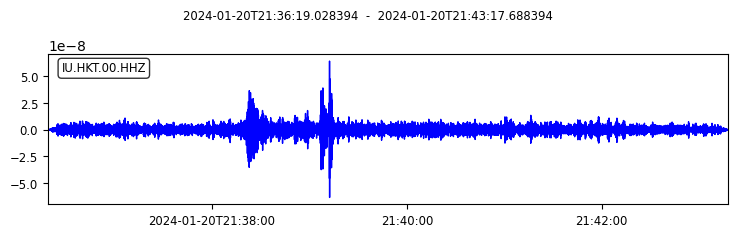

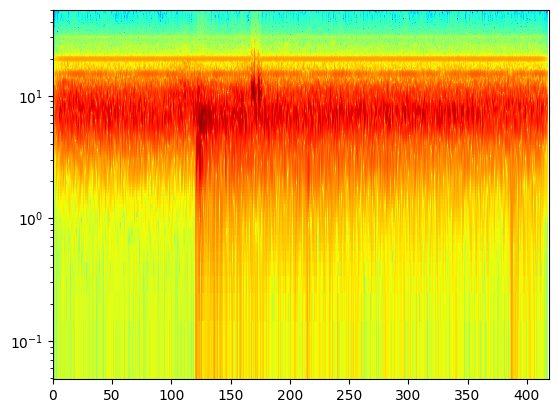

In [7]:
# Import obspy Stream
from obspy import Stream

# BHZ trace. Check.
# Read a trace from the stream object.
tr = st[2]
print(tr.stats.channel)
tr.plot()

# corners=filter order; zerophase=True, results in a zero phase shift.
#tr.filter("highpass", freq=6.)
tr.filter("bandpass", freqmin=6., freqmax=11.)

# Plot filtered trace
tr.plot(color = 'blue');

# Plot spectograms
fig, ax = plt.subplots()
_ = tr.spectrogram(log=True, dbscale=True, axes=ax, show=True, cmap = "jet")